In [82]:
#!pip install tensorflow
#!pip install -q pyyaml h5py
#!pip install tf-nightly

In [34]:
#!pip install -q tensorflow-hub

In [42]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import os

import matplotlib.pylab as plt

In [37]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [38]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [7]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
#checkpoint_folder = folder to save the model
#PATH = folder to retrieve images for trainig

In [12]:

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'test')

train_good_dir = os.path.join(train_dir, 'Good')
train_bad_dir = os.path.join(train_dir, 'Bad')
validation_good_dir = os.path.join(validation_dir, 'Good')
validation_bad_dir = os.path.join(validation_dir, 'Bad')

num_good_tr = len(os.listdir(train_good_dir))
num_bad_tr = len(os.listdir(train_bad_dir))

num_good_val = len(os.listdir(validation_good_dir))
num_bad_val = len(os.listdir(validation_bad_dir))

total_train = num_good_tr + num_bad_tr
total_val = num_good_val + num_bad_val
print('total training good images:', num_good_tr,"(",100*num_good_tr/total_train,"%)" )
print('total training bad images:', num_bad_tr,"(",100*num_bad_tr/total_train,"%)")
print('total validation good images:', num_good_val,"(",100*num_good_val/total_val,"%)")
print('total validation bad images:', num_bad_val,"(",100*num_bad_val/total_val,"%)")
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training good images: 96 ( 41.02564102564103 %)
total training bad images: 138 ( 58.97435897435897 %)
total validation good images: 12 ( 35.294117647058826 %)
total validation bad images: 22 ( 64.70588235294117 %)
--
Total training images: 234
Total validation images: 34


In [13]:
# Controlliamo se ci sono duplicati nelle cartelle ed in caso andremo a rimuoverli manualmente
x = [f for f in os.listdir(train_good_dir)]+[f for f in os.listdir(train_bad_dir)]+[f for f in os.listdir(validation_good_dir)]+ [f for f in os.listdir(validation_bad_dir)]
from collections import Counter
c= Counter(x)
for key,value in c.items():
    if value > 1:
        print("File ",key)
        print("It is in:")
        if key in [f for f in os.listdir(train_good_dir)]:
            print(os.path.join(train_good_dir, key))
        if key in [f for f in os.listdir(train_bad_dir)]:
            print(os.path.join(train_bad_dir, key))
        if key in [f for f in os.listdir(validation_good_dir)]:
            print(os.path.join(validation_good_dir, key))
        if key in [f for f in os.listdir(validation_bad_dir)]:
            print(os.path.join(validation_bad_dir, key))

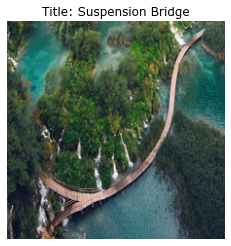

In [16]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = classifier.predict(im[np.newaxis, ...])
#result.shape
predicted_class = np.argmax(result[0], axis=-1)
#predicted_class
plt.imshow(im)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Title: " + predicted_class_name.title())

In [17]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)

In [54]:
batch_size = 15
epochs = 7

In [19]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = train_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = validation_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')

Found 234 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [20]:
sample_train_images, _ = next(train_data_gen)
#sample_train_images.shape

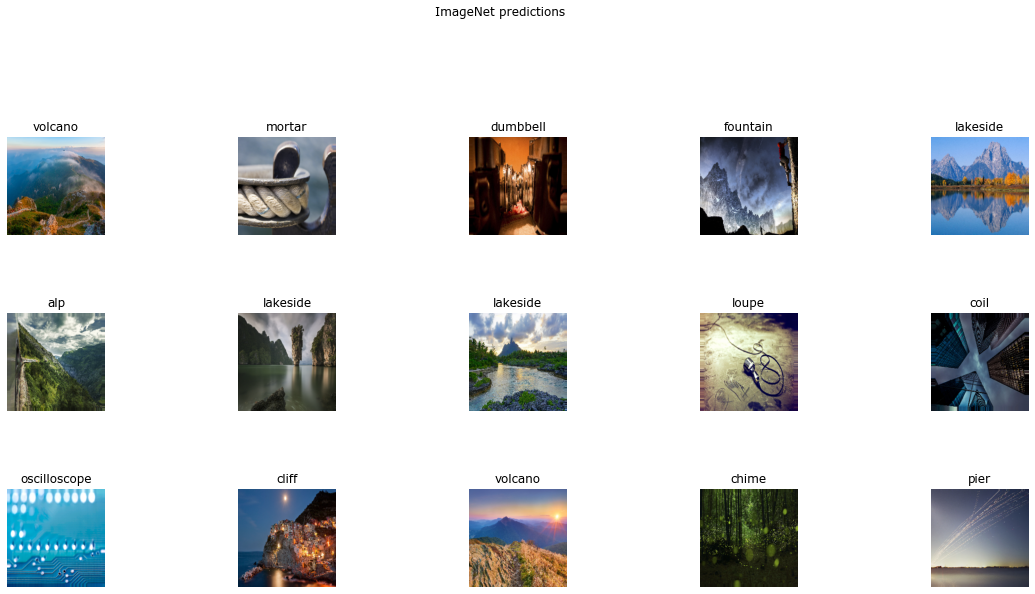

In [21]:
result_batch = classifier.predict(sample_train_images)
#result_batch.shape
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
#predicted_class_names
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [22]:
classifier.trainable=False

In [23]:
model = tf.keras.Sequential([
  classifier,
  layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 1)                 1002      
Total params: 3,541,267
Trainable params: 1,002
Non-trainable params: 3,540,265
_________________________________________________________________


In [24]:
#predictions = model(sample_train_images)
#predictions.shape

In [25]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.0007
)
model.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC','Precision'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

Epoch 1/10
15/15 [==============================] - 18s 1s/step - loss: 0.7623 - acc: 0.5662 - auc: 0.6012 - precision: 0.4681 - val_loss: 0.7290 - val_acc: 0.6667 - val_auc: 0.7199 - val_precision: 0.5714
Epoch 2/10
15/15 [==============================] - 13s 898ms/step - loss: 0.6024 - acc: 0.6530 - auc: 0.7322 - precision: 0.5556 - val_loss: 0.7978 - val_acc: 0.6333 - val_auc: 0.6435 - val_precision: 0.5333
Epoch 3/10
15/15 [==============================] - 13s 862ms/step - loss: 0.6614 - acc: 0.6438 - auc: 0.6997 - precision: 0.5926 - val_loss: 0.7240 - val_acc: 0.7000 - val_auc: 0.6713 - val_precision: 0.6000
Epoch 4/10
15/15 [==============================] - 13s 839ms/step - loss: 0.4918 - acc: 0.7306 - auc: 0.8240 - precision: 0.6700 - val_loss: 0.7078 - val_acc: 0.6667 - val_auc: 0.6620 - val_precision: 0.6000
Epoch 5/10
15/15 [==============================] - 12s 809ms/step - loss: 0.5136 - acc: 0.7489 - auc: 0.8173 - precision: 0.6449 - val_loss: 0.7113 - val_acc: 0.6000 

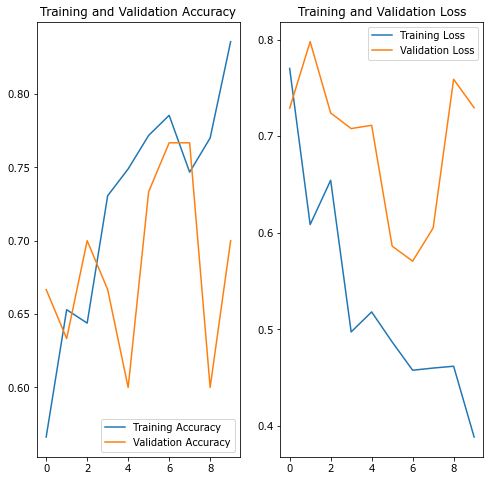

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

D:\Users\rdemaio\Anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


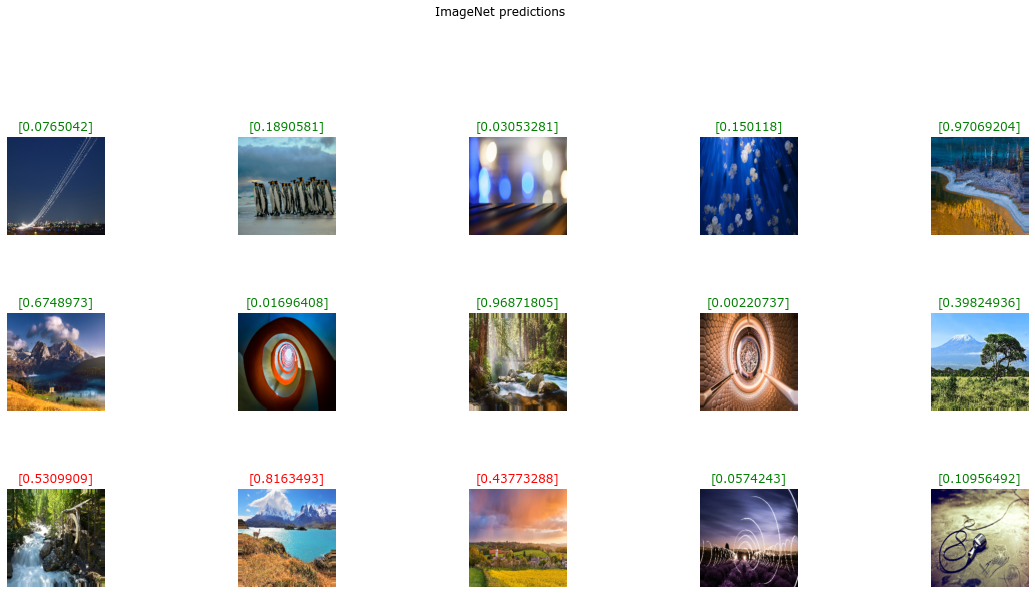

In [31]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model.predict(sample_train_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [45]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [46]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3),
                                        trainable=False)

In [57]:
model_2 = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(1,activation = 'sigmoid')
])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [58]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.001
)
model_2.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC'])

In [59]:
history = model_2.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

Epoch 1/7
15/15 [==============================] - 16s 1s/step - loss: 0.7923 - acc: 0.4932 - auc_8: 0.4634 - val_loss: 0.7238 - val_acc: 0.5333 - val_auc_8: 0.5370
Epoch 2/7
15/15 [==============================] - 14s 938ms/step - loss: 0.7074 - acc: 0.5467 - auc_8: 0.5785 - val_loss: 0.6850 - val_acc: 0.6000 - val_auc_8: 0.6366
Epoch 3/7
15/15 [==============================] - 13s 879ms/step - loss: 0.6276 - acc: 0.6244 - auc_8: 0.6945 - val_loss: 0.6245 - val_acc: 0.6000 - val_auc_8: 0.6968
Epoch 4/7
15/15 [==============================] - 13s 840ms/step - loss: 0.5949 - acc: 0.6484 - auc_8: 0.7208 - val_loss: 0.5445 - val_acc: 0.7667 - val_auc_8: 0.7778
Epoch 5/7
15/15 [==============================] - 13s 874ms/step - loss: 0.5215 - acc: 0.6978 - auc_8: 0.8011 - val_loss: 0.5673 - val_acc: 0.6333 - val_auc_8: 0.7616
Epoch 6/7
15/15 [==============================] - 12s 810ms/step - loss: 0.5355 - acc: 0.7136 - auc_8: 0.8067 - val_loss: 0.5964 - val_acc: 0.6667 - val_auc_8: 0.

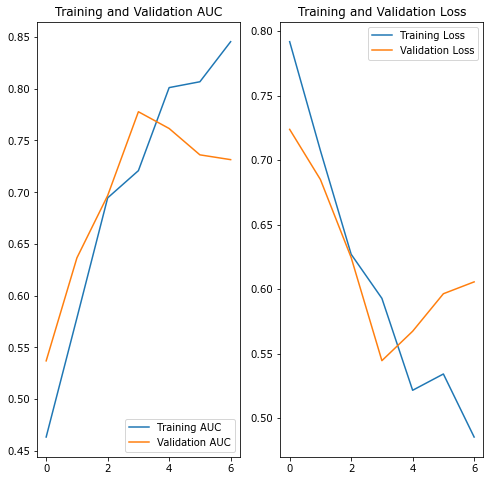

In [60]:
acc = history.history['auc_8']
val_acc = history.history['val_auc_8']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC')
plt.plot(epochs_range, val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

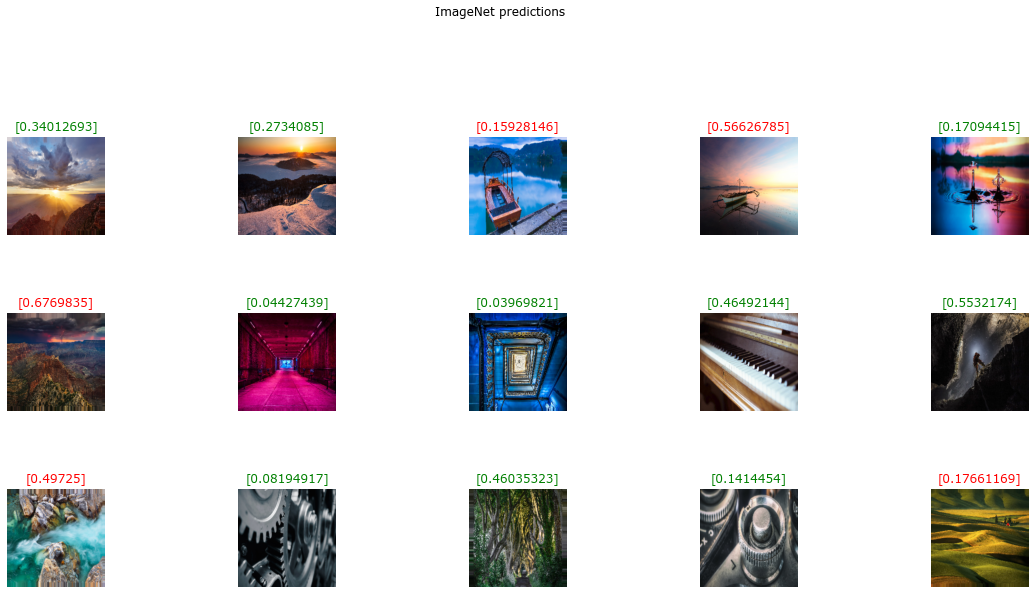

In [70]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model_2.predict(sample_val_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_val_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [88]:
#Saved Chosen Model
model_2.save("../checkpoints/ImagePicker/model.h5")

In [94]:
#Check Load method
new_model = tf.keras.models.load_model("../checkpoints/ImagePicker/model.h5",custom_objects={'KerasLayer':hub.KerasLayer})

# Check its architecture
new_model.summary()

ValueError: Unknown entries in loss dictionary: ['class_name', 'config']. Only expected following keys: ['dense_2']

In [77]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = model_2.predict(im[np.newaxis, ...])
result.shape
#plt.imshow(im)
#plt.axis('off')
#predicted_class_name = imagenet_labels[predicted_class]
#_ = plt.title("Prediction: " + predicted_class_name.title())

(1, 1)

In [96]:
handle_base = "mobilenet_v2_100_224"

import os

os.environ["TFHUB_CACHE_DIR"] = "/tmp/model"


MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SHAPE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [ ]:
do_fine_tuning = False 

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1,
                          activation = 'sigmoid',
                         # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
                         )
])
model.build((None,)+IMAGE_SHAPE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


In [ ]:
model.compile(
  optimizer='adam' 
    #tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
  metrics=['accuracy','AUC'])

In [109]:
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = 5,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)
)

Epoch 1/5
15/15 [==============================] - 47s 3s/step - loss: 0.8018 - acc: 0.4886 - auc_14: 0.5234 - val_loss: 0.5020 - val_acc: 0.7333 - val_auc_14: 0.8750
Epoch 2/5
15/15 [==============================] - 32s 2s/step - loss: 0.6567 - acc: 0.6438 - auc_14: 0.7092 - val_loss: 0.4671 - val_acc: 0.7000 - val_auc_14: 0.8200
Epoch 3/5
15/15 [==============================] - 39s 3s/step - loss: 0.6013 - acc: 0.7215 - auc_14: 0.7844 - val_loss: 0.6130 - val_acc: 0.6333 - val_auc_14: 0.7875
Epoch 4/5
 6/15 [===========>..................] - ETA: 16s - loss: 0.6954 - acc: 0.6786 - auc_14: 0.7504

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'D:\\Users\\rdemaio\\Anaconda3\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.



  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard_plugin_wit-1.7.0-py3-none-any.whl (779 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached rsa-4.6-py3-none-any.whl (47 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached cachetools-4.1.1-py3-none-any.whl (10 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstal

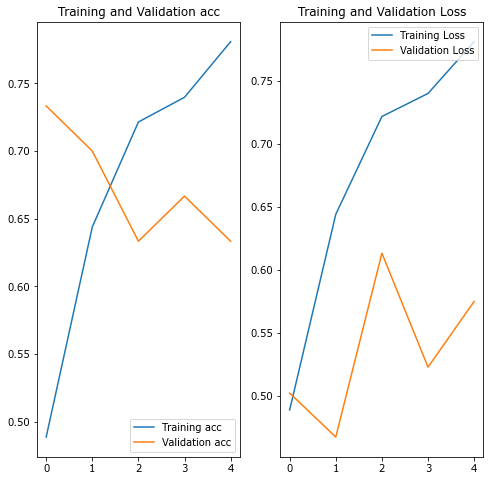

In [115]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['acc']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training acc')
plt.plot(epochs_range, val_acc, label='Validation acc')
plt.legend(loc='lower right')
plt.title('Training and Validation acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

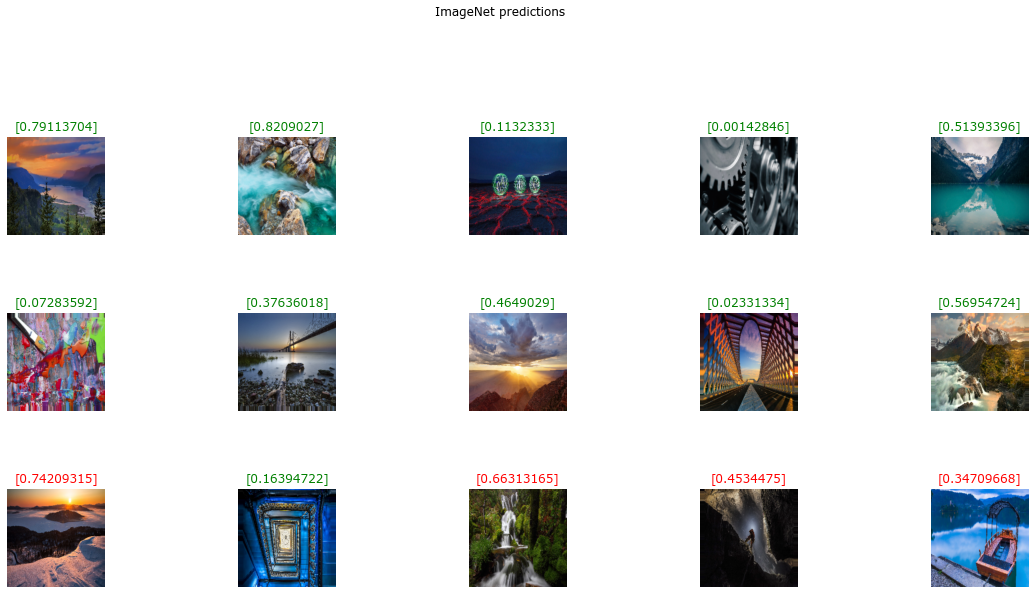

In [119]:
THRESHOLD = 0.5

sample_val_images, sample_label_images = next(val_data_gen)
result_batch = model.predict(sample_val_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_val_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [149]:
model.save('../checkpoints/saved_model/model.h5')

In [157]:
tf.saved_model.save(model,'../checkpoints/saved_model/')

ValueError: None values not supported.

In [155]:
new_model = tf.keras.experimental.load_from_saved_model('../checkpoints/saved_model/model.h5')

NotFoundError: NewRandomAccessFile failed to Create/Open: ../checkpoints/saved_model/model.h5\assets\saved_model.json : The system cannot find the path specified.
; No such process

In [ ]:
new_model.get_config()